![Py4Eng](../logo.png)

# Feed Forward Network
## Yoav Ram

Here we will introduce **feed forward networks** (FFN), also called 
**multilayer perceptron** (MLP), as the basic artificial neural network architecture (ProbML, ch. 13).

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as np
import jax
from jax import random
from jax.scipy import stats, optimize
from jax.scipy.special import expit, logit
import scipy.ndimage
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
red, blue, green = sns.color_palette('Set1', 3)
from sklearn.metrics import confusion_matrix

def display_image(im, ax=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(im.reshape(28,28), cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])

We start by loading the MNIST digits data we used in the previous session.


In [13]:
import keras
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

In [14]:
X_train = X_train.reshape(-1, 28*28)/255
X_test = X_test.reshape(-1, 28*28)/255

Y_train = jax.nn.one_hot(Y_train, 10)
Y_test = jax.nn.one_hot(Y_test, 10)

With softmax regression we got accuracy of ~90%.
But we talked about the problems with logistic models and that it might be that the relationship between pixels and categories is not linear or even monotone.

We will try to solve it by layering or composing of several linear models.
This kind of model is called a **feed forward network**.

# Two layer FFN

We start with just two layers.
The input is $x^{(1)}_i$, which is transformed to a latent feature vector $x^{(2)}_i$, which is then transformed to the prediction $\hat{y}_i$:
$$
z^{(1)}_i = W^{(1)} x^{(1)}_i $$$$
x^{(2)}_i = f_1(z^{(1)}_i) $$$$
z^{(2)}_i = W^{(2)} x^{(2)}_i $$$$
\hat{y}_i = \text{softmax}(z^{(2)}_i) $$$$
y_i \sim \text{Cat}(\hat{y}_i)
$$
The second layer is the softmax regression layer.
The first layer is the hidden layer.

# ReLU

We need a non-linear **activation function**, $f_1$, between the layers; otherwise the two linear models will collapse into a single linear model.
For ease of use, we want a differentiable function that's easy and efficient to compute.

There are several options we can use, and a common choise is the rectifier, or [*ReLU*](https://en.wikipedia.org/wiki/Rectifier_%28neural_networks%29) function (PRobML 13.4.3.1):

$$
\text{relu}(x) = \cases{x, & if x>0 \\ 0, & if x < 0}
$$

with a derivative

$$
\partial \text{relu}(x) = \cases{1, & if x>0 \\ 0, & if x < 0}
$$

Note that we can also just use the JAX implementation, `jax.nn.relu`.

In [15]:
def relu(X):
    return np.maximum(X, 0)

def drelu(X):
    return (X>0).astype(np.float32)

In [16]:
relu(np.linspace(-1, 1, 10))

Array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11111113, 0.33333337, 0.5555556 , 0.7777778 , 1.        ],      dtype=float32)

In [17]:
drelu(np.linspace(-1, 1, 10))

Array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)

# Dropout

A simple way to avoid overfitting is to use [*dropout*](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf): randomly ignoring some elements of every layer during training (but not during prediction).

In [20]:
def dropout(X, key, keep_prob=1):
    if keep_prob < 1:
        X = X.copy() # we don't want to change X
        keeps = random.uniform(key, shape=(X.shape[1],)) < keep_prob
        # X.shape is (nsamples, nfeatures)
        X = X.at[:, ~keeps].set(0) # ignore # X[:, ~keeps] = 0
        X = X.at[:, keeps].mul(1/keep_prob) # normalize # X[:, keeps] *= 1/keep_prob
    return X

In [21]:
dropout(np.ones((5,5)), jax.random.PRNGKey(1), keep_prob=0.5)

Array([[0., 2., 2., 0., 0.],
       [0., 2., 2., 0., 0.],
       [0., 2., 2., 0., 0.],
       [0., 2., 2., 0., 0.],
       [0., 2., 2., 0., 0.]], dtype=float32)

# Feed Forward

Next, we want to write a function that for given input $x^{(1)}_i$ calculates $\hat{y}_i$.
But we also want to get all the intermediate layers, not just the final layer (the output, result of the readout layer).
The reason will become clear soon, when we write the back-propagation.

Prediction is then done by taking the last layer.

In [22]:
def feed_forward(Ws, X, key=None, keep_prob=1):
    X = np.atleast_2d(X)
    
    X1 = X
    W1, W2 = Ws
    
    # hidden layer
    Z1 = X1 @ W1 
    Z1 = dropout(Z1, key, keep_prob=keep_prob)
    X2 = relu(Z1) 
    
    # readout layer
    Z2 = X2 @ W2 
    Yhat = jax.nn.softmax(Z2) 
    return [X1, Z1, X2, Z2, Yhat]

def predict(Ws, X):    
    return feed_forward(Ws, X)[-1]

def accuracy(Ws, X, Y):
    Yhat = predict(Ws, X)
    return (Yhat.argmax(axis=1) == Y.argmax(axis=1)).mean()
    
def display_prediction(idx):
    prediction = predict(Ws, X_test[idx, :]).argmax()
    print(prediction)
    return display_image(X_test[idx].reshape((28,28)))

0


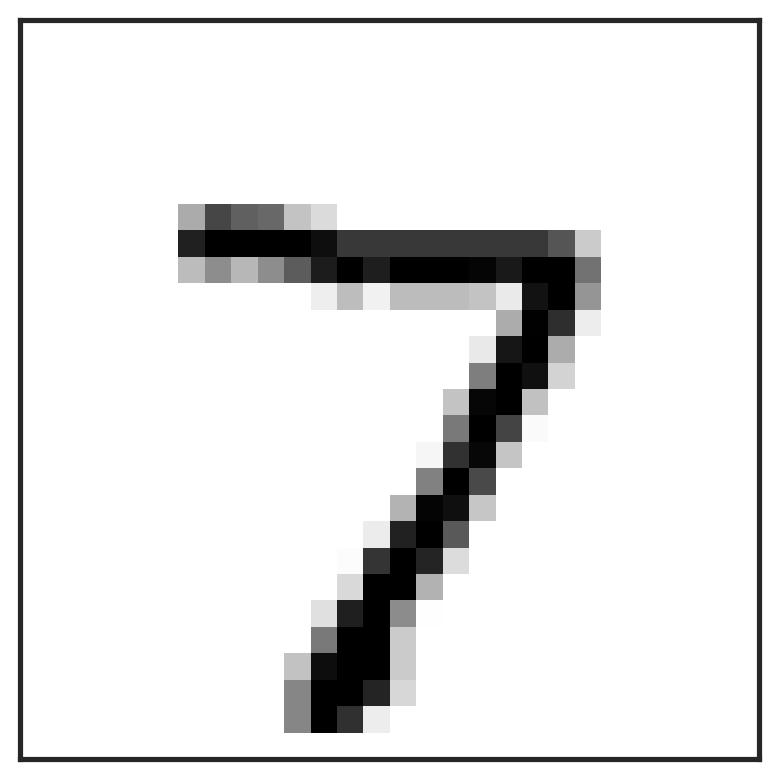

In [23]:
nfeatures = X_train.shape[1]
ncats = Y_train.shape[1]
nhidden = 100
W1 = np.ones((nfeatures, nhidden))
W2 = np.ones((nhidden, ncats))
Ws = [W1, W2]

display_prediction(0)

# Back propagation

We now arrive at the most complicated and important part: the calculation of the gradeints of the loss function with respect to the $W^{(k)}$ matrices - the model parameters, the weights of the network.

The loss is the NLL functions, which is still the cross-entropy function.
We actually know how to calculate the gradient at each layer, so calculating the gradient of $NLL$ with respect to any $W^{(k)}$ is just a matter of applying the chain rule as many times as we need.
We apply the chain rule in reverse iteration to calculate the gradient of the loss function with respect to all parameters.

Since the gradient at any layer is calculated as a function of the error measured in the previous layer, we essentially propagate the error backwards, thus the name for this algorithm - [**back propagation**](https://en.wikipedia.org/wiki/Backpropagation) (ProbML ch. 13.3).

To calculate $\partial NLL/\partial W^{(2)}$ we have the exact same calculation as in the logistic or softmax regression (makes sense as the second layer is a softmax layer),
$$
\frac{\partial NLL}{\partial W^{(2)}} =
\frac{\partial NLL}{\partial \hat{y}} \cdot 
\frac{\partial \hat{y}}{\partial z^{(2)}} \cdot
\frac{\partial z^{(2)}}{\partial W^{(2)}}
$$

To calculate $\partial NLL/\partial W^{(1)}$ we can use a similar but longer calculation,
$$
\frac{\partial NLL}{\partial W^{(1)}} = 
\frac{\partial NLL}{\partial \hat{y}} \cdot 
\frac{\partial \hat{y}}{\partial z^{(2)}} \cdot 
\frac{\partial z^{(2)}}{\partial x^{(2)}} \cdot 
\frac{\partial x^{(2)}}{\partial z^{(1)}} \cdot 
\frac{\partial z^{(1)}}{\partial W^{(1)}} \cdot 
$$

Note that the first terms of this product were already calculated when calculating $\frac{\partial NLL}{\partial W^{(2)}}$; the term 

$$
\delta_2 = \frac{\partial NLL}{\partial \hat{y}} \cdot
\frac{\partial\hat{y}}{\partial z^{(2)}}
$$
is the error of the previous layer, and it is back-propagated to the next layer:
$$
\frac{\partial NLL}{\partial W^{(1)}} = 
\
\delta_2 \cdot 
\frac{\partial z^{(2)}}{\partial x^{(2)}} \cdot 
\frac{\partial x^{(2)}}{\partial z^{(1)}} \cdot 
\frac{\partial z^{(1)}}{\partial W^{(1)}} \cdot 
$$

So we have three simple opeations:
$$
\frac{\partial z^{(2)}}{\partial x^{(2)}} = W^{(2)}
$$$$
\frac{\partial x^{(2)}}{\partial z^{(1)}} = \partial \text{relu}
$$$$
\frac{\partial z^{(1)}}{\partial W^{(1)}} = x^{(1)}
$$

In the next layer $\delta_1$ is updated to 
$$
\delta_1 = 
\delta_2 \cdot 
\frac{\partial z^{(2)}}{\partial x^{(2)}} \cdot 
\frac{\partial x^{(2)}}{\partial z^{(1)}} = 
\delta_2 \cdot W_2 \cdot \partial \text{relu}
$$
thus *propagating back* the error $\delta$.

Consider that in forwarding we use the matrix multiplication to activate each node as a weighted average of the previous nodes (the weights given by $W^{(k)}$). 
Back propagation can be considered the reverse operation.

The actual operators used below are chosen to avoid loops (except the loop through the layers which is unavoiable) and to keep the correct dimensions.

In [24]:
def NLL(Ws, X, Y):
    Yhat = predict(Ws, X)
    return -(Y * np.log(Yhat)).sum()

In [25]:
def backprop(Ws, X, Y, key=None, keep_prob=1):
    W1, W2 = Ws
    X1, Z1, X2, Z2, Yhat = feed_forward(Ws, X, key, keep_prob=keep_prob)

    # readout layer
    δ2 = Yhat - Y # prediction error, dNLL/dYhat * dYhat/dZ2 (-1, ncats)
    G2 = X2.T @ δ2 # dNLL/dW2 = δ2 * dZ2/dX2 = δ2 * X2

    # hidden layer
    δ1 = (δ2 @ W2.T) * drelu(Z1) # δ1 = dJ/dX_2 = δ2 * dZ2/dX2 * dX2/dZ1 = δ2 * W2 * ReLU(Z1)
    G1 = X1.T @ δ1 # dNLL/dW1 = δ1 * dZ1/dW1 = δ1 * X1

    Gs = [G1, G2]
    
    # sanity checks
    assert len(Gs) == len(Ws), (len(Gs), len(Ws))
    for Gi, Wi in zip(Gs, Ws):
        assert Gi.shape == Wi.shape, (Gi.shape, Wi.shape)
    return Gs

In [26]:
nhidden = 100
W1 = np.ones((nfeatures, nhidden))
W2 = np.ones((nhidden, ncats))
Ws = [W1, W2]

X_, Y_ = X_train[:50, :], Y_train[:50, :]
backprop(Ws, X_, Y_);

# Gradient checking

Writing and implementing the gradient computation can be really hard.
But there is a good way to sanity-check that we made the correct computation.

Remember that the definition of a derivative is
$$
\frac{d f}{d x}\big(x\big) = \lim_{\Delta \to 0}{\frac{f(x+\Delta) - f(x-\Delta)}{2\Delta}}
$$
Therefore, we can compute the cross entropy at the params, then slightly change each parameter and compute the cross entropy again, and use these two computations as $f(x+\Delta)$ and $f(x-\Delta)$ where $x$ is the parameter we changed and $\Delta$ is the slight change. 
Then we can compare $\frac{f(x+\Delta)-f(x-\Delta)}{2\Delta}$ to the gradient computed by back propagation and check that the difference is very small.

However, because we have the power of JAX, we can do something better.

# Automatic differentiation with JAX

Instead of manually deriving the gradient and implementing it as a Python program, we use *JAX's automatic differentiation**.

[`jax.grad`](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#taking-derivatives-with-grad) takes a function `f(a, b, c)` and returns a function `dfda(a, b, c)` that returns the gradient of `f` with respect to `a` at the values of `a`, `b`, and `c`. It does so by automating the procedure we did manually using the chain rule.

In our case, `f` is `NLL`, `a` is `Ws`, and `b` and `c` are `X` and `Y`.

In [52]:
backprop_jax = jax.grad(NLL)
backprop_jax(Ws, X_train[:50, :], Y_train[:50, :]);

In [53]:
def gradient_check(Ws, X, Y):
    grads1 = backprop(Ws, X, Y)    
    grads2 = backprop_jax(Ws, X, Y) 
    for g1, g2 in zip(grads1, grads2):
        assert np.allclose(g1, g2, atol=1e-5)

In [54]:
nhidden = 10
W1 = np.ones((nfeatures, nhidden))
W2 = np.ones((nhidden, ncats))
Ws = [W1, W2]

X_, Y_ = X_train[:50, :], Y_train[:50, :]
gradient_check(Ws, X_, Y_)

# Momentum gradient descent

There are different ways to perform stochastic gradient descent.
Some of the algorithms adapt the learning rate $\eta$ during training (ProbML ch. . 
The basic intuition is that when we are far from the minimum we want to advance in big steps and when we are near to the minimum we want to advance more carefully.

We will use the method described in [Rumelhart, Hinton & Williams, 1986](http://www.nature.com/doifinder/10.1038/323533a0).
It is a momentum method, meaning that at each iteration (batch) the next update $\Delta W_t$ is calculated as a decaying average of the previous update $\Delta W_{t-1}$ and the current gradient $\frac{\partial NLL}{\partial W}(W_{t-1})$,
$$
\Delta W_t = \alpha \Delta W_{t-1} - \eta \frac{\partial NLL}{\partial W}(W_{t-1}) $$$$
W_t = W_{t-1} + \Delta W_t
$$
It simple and easy to implement and gives a good sense of what other momentum-based algorithms do.
See a [comparison of algorithms on MNIST](https://github.com/mazefeng/sgd-opt).
See ProbML ch. 8.2.4 for other variants of momentum gradient descent and ProbML ch. 8.4.6 for other popular methods like **AdaGrad** and **Adam**.

In [27]:
def momentum(Gs, ΔWs, α=0.9, η=0.05): 
    ΔWs = [
        α * ΔW - η * G
        for ΔW, G in zip(ΔWs, Gs)
    ]        
    return ΔWs

In [28]:
ΔWs = [0.0] * len(Ws)
Gs = backprop(Ws, X_train[:50], Y_train[:50])
ΔWs = momentum(Gs, ΔWs)

# JITing the training step

We write a function that does a single gradient descent step, and pass it to `jax.jit`, which [just-in-time compiles the function](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html) so it can be executed efficiently in XLA.

We return: 
- `Ws` (the parameters) because that's what we are interested in
- `ΔWs` (the updates) so we can use it in the next iteration
- `Gs` (the gradients) for debugging (see below).

In [29]:
@jax.jit # reduces running time from 2 ms to 600 µs
def gradient_descent(Ws, ΔWs, X, Y, η):
    X = np.atleast_2d(X) # consistent with scikit-learn and keras that want X to be 2D    
    Gs = backprop(Ws, X, Y)
    ΔWs = momentum(Gs, ΔWs, η=η) 
    Ws = [W + ΔW for W, ΔW in zip(Ws, ΔWs)]
    return Ws, Gs, ΔWs 

gradient_descent(Ws, ΔWs, X_train[:50], Y_train[:50], η=0.05);

In [20]:
%timeit gradient_descent(Ws, ΔWs, X_train[:50], Y_train[:50], η=0.05);

192 μs ± 9.74 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Parameter initialization

The loss of FFN is non-convex. Therefore, there may be multiple local minima and other convergence issues. Thus, the solution and speed of convergence can be affected by the way we initialize the parameters  (ProbML ch. 13.4.5).

A major consideration is keeping the gradients and the gradient descent updates from blowing up. We want both $n_{out}\sigma^2=1$ and $n_{in}\sigma^2=1$, where $n_{out}$ and $n_{in}$ are the number of inputs and outputs of a later (i.e., the dimensions of $W$). This gives us $\sigma^2=\frac{2}{n_{in}+n_{out}}$. This gives us the **Glorot uniform initialization** (also called **Xavier uniform initialization**),
$$
W_{i,j} \sim \text{Uniform}(-a, a), \quad a=\sqrt{\frac{6}{n_{in}+n_{out}}}
$$
A similar approach gives the **Glorot normal initialization**. Similar approaches are called **He initialization** and **LeCun initialization** (ProbML ch. 13.4.5.1).
These are implemented in `jax.nn.initializers`, but we implement Glorot uniform here.

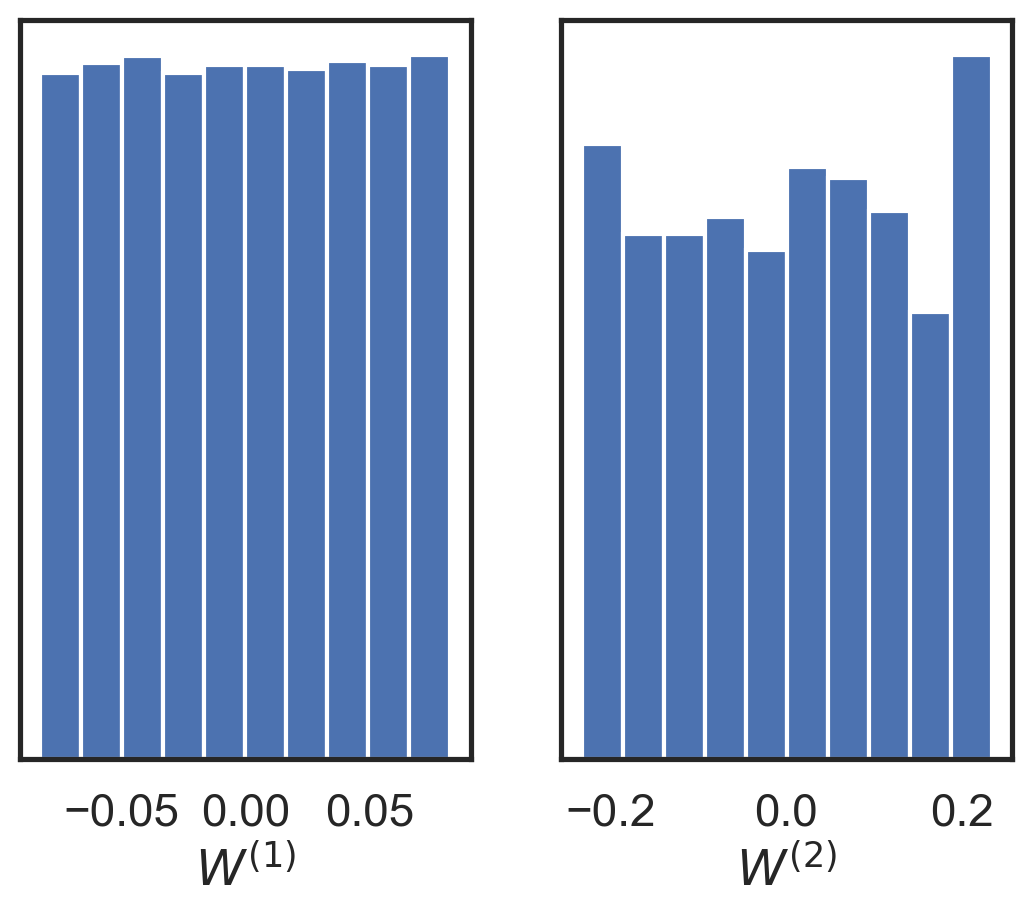

In [30]:
def glorot_uniform(key, nin, nout):
    a = np.sqrt(6 / (nin + nout))
    return random.uniform(key, shape=(nin, nout), minval=-a, maxval=a)

W1 = glorot_uniform(random.PRNGKey(21), nfeatures, nhidden)
W2 = glorot_uniform(random.PRNGKey(12), nhidden, ncats)

fig, axes = plt.subplots(1, 2)
axes[0].hist(W1.ravel())
axes[1].hist(W2.ravel())
axes[0].set(xlabel='$W^{(1)}$', yticks=[])
axes[1].set(xlabel='$W^{(2)}$', yticks=[]);

# Training the FFN

In [31]:
def train(Ws, num_epochs, η, debug=False):
    n = X_train.shape[0]
    epochs = 0
    batches = 0
    ΔWs = [0] * len(Ws)

    while epochs < num_epochs:
        batches += 1
        epochs = batches * batch_size // n
        
        # get next batch
        start = (batches * batch_size) % n
        stop = start + batch_size
        X_, Y_ = X_train[start:stop, :], Y_train[start:stop, :]
        
        # gradient descent
        Ws, Gs, ΔWs = gradient_descent(Ws, ΔWs, X_, Y_, η=η)
        
        # print once every epoch
        if batches * batch_size % n == 0:
            acc = accuracy(Ws, X_test, Y_test)
            print("Epoch {}, test accuracy: {:.4f}".format(epochs, acc))   
            if debug:
                print("Gradients:")
                for G in Gs:
                    print('\t', G.min(), G.mean(), G.max())
    return Ws

In [32]:
batch_size = 50 

nhidden = 100
W1 = glorot_uniform(random.key(21), nfeatures, nhidden)
W2 = glorot_uniform(random.key(12), nhidden, ncats)
Ws = [W1, W2]

print("Accuracy: {:.4f}".format(accuracy(Ws, X_test, Y_test)))

Accuracy: 0.0897


In [33]:
Ws = train(Ws, 3, η=0.05)

Epoch 1, test accuracy: 0.0980
Epoch 2, test accuracy: 0.0980
Epoch 3, test accuracy: 0.0980


Training is stuck. Let's look at the gradients.

In [34]:
W1 = glorot_uniform(random.key(21), nfeatures, nhidden)
W2 = glorot_uniform(random.key(12), nhidden, ncats)
Ws = [W1, W2]

Ws = train(Ws, 3, η=0.05, debug=True)

Epoch 1, test accuracy: 0.0980
Gradients:
	 0.0 0.0 0.0
	 0.0 0.0 0.0
Epoch 2, test accuracy: 0.0980
Gradients:
	 0.0 0.0 0.0
	 0.0 0.0 0.0
Epoch 3, test accuracy: 0.0980
Gradients:
	 0.0 0.0 0.0
	 0.0 0.0 0.0


That's not good, the gradients are all zero. Let's try a lower learning rate $\eta$.

In [37]:
W1 = glorot_uniform(random.key(21), nfeatures, nhidden)
W2 = glorot_uniform(random.key(12), nhidden, ncats)

Ws = [W1, W2]

Ws = train(Ws, 3, η=0.0001)

Epoch 1, test accuracy: 0.9223
Epoch 2, test accuracy: 0.9395
Epoch 3, test accuracy: 0.9497


Now it's working, let run it for more epochs.

In [64]:
Ws = train(Ws, 30, η=0.0001)

Epoch 1, test accuracy: 0.9548
Epoch 2, test accuracy: 0.9599
Epoch 3, test accuracy: 0.9642
Epoch 4, test accuracy: 0.9671
Epoch 5, test accuracy: 0.9686
Epoch 6, test accuracy: 0.9708
Epoch 7, test accuracy: 0.9714
Epoch 8, test accuracy: 0.9724
Epoch 9, test accuracy: 0.9727
Epoch 10, test accuracy: 0.9737
Epoch 11, test accuracy: 0.9742
Epoch 12, test accuracy: 0.9744
Epoch 13, test accuracy: 0.9745
Epoch 14, test accuracy: 0.9747
Epoch 15, test accuracy: 0.9749
Epoch 16, test accuracy: 0.9755
Epoch 17, test accuracy: 0.9757
Epoch 18, test accuracy: 0.9758
Epoch 19, test accuracy: 0.9762
Epoch 20, test accuracy: 0.9766
Epoch 21, test accuracy: 0.9766
Epoch 22, test accuracy: 0.9769
Epoch 23, test accuracy: 0.9771
Epoch 24, test accuracy: 0.9772
Epoch 25, test accuracy: 0.9773
Epoch 26, test accuracy: 0.9776
Epoch 27, test accuracy: 0.9780
Epoch 28, test accuracy: 0.9778
Epoch 29, test accuracy: 0.9779
Epoch 30, test accuracy: 0.9780


Great! We trained our FFN to a very high accuracy! 

0


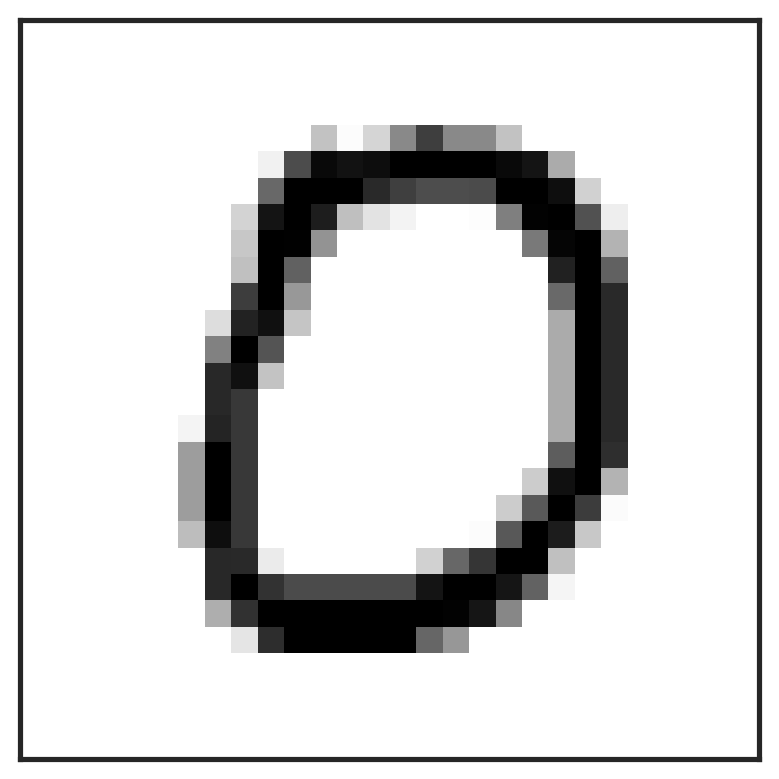

In [65]:
display_prediction(10)

# Confusion

We can also explore the confusion matrix to see which digits are commonly confused with which digits.

In [66]:
y_true = Y_test.argmax(axis=1)
y_pred = predict(Ws, X_test).argmax(axis=1)

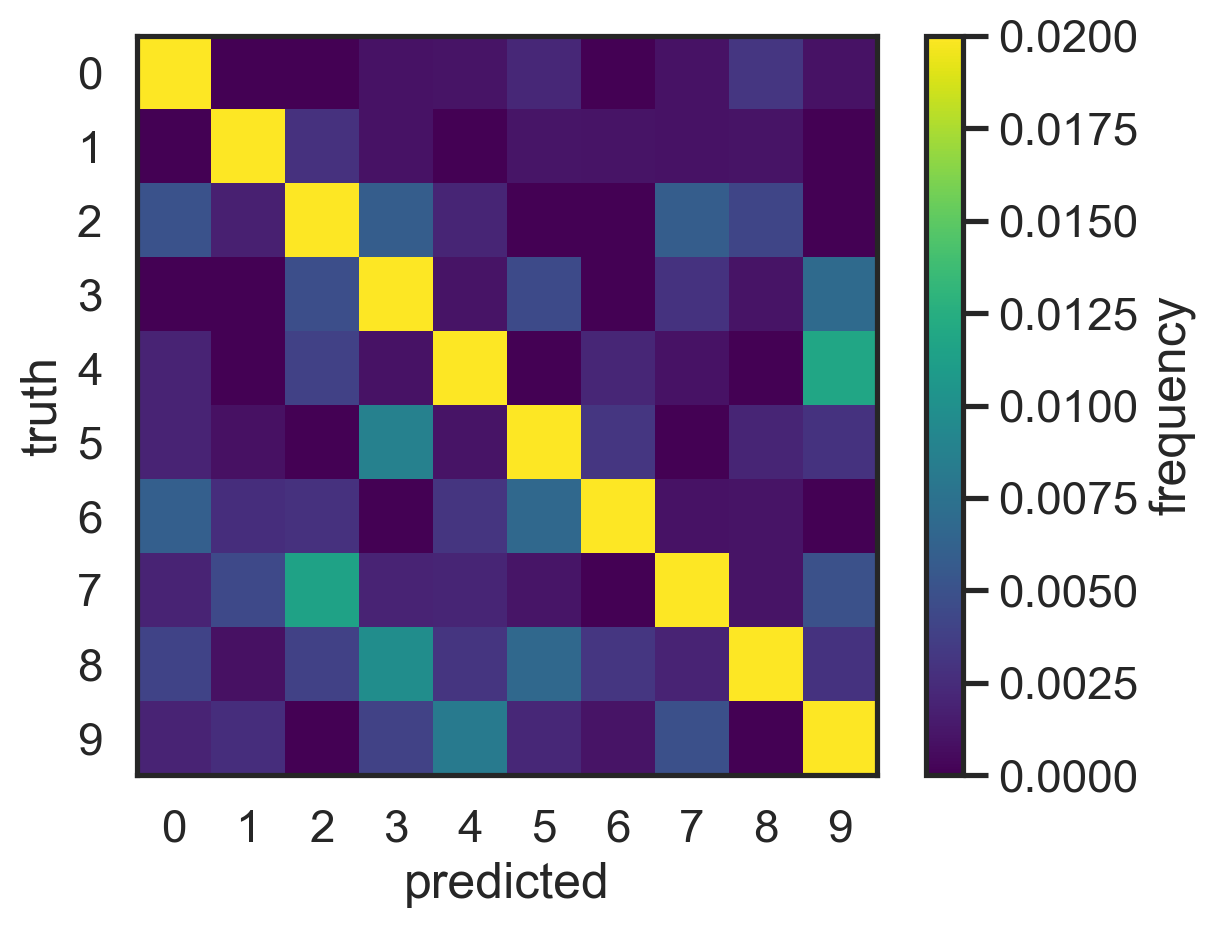

In [67]:
conf = confusion_matrix(y_true, y_pred, normalize='pred')
plt.imshow(conf, origin='upper', cmap='viridis', vmin=0, vmax=0.02)
plt.xlabel('predicted')
plt.ylabel('truth');
plt.xticks(range(10))
plt.yticks(range(10))
plt.colorbar(label='frequency');

Here we explore specific cases of confusion.

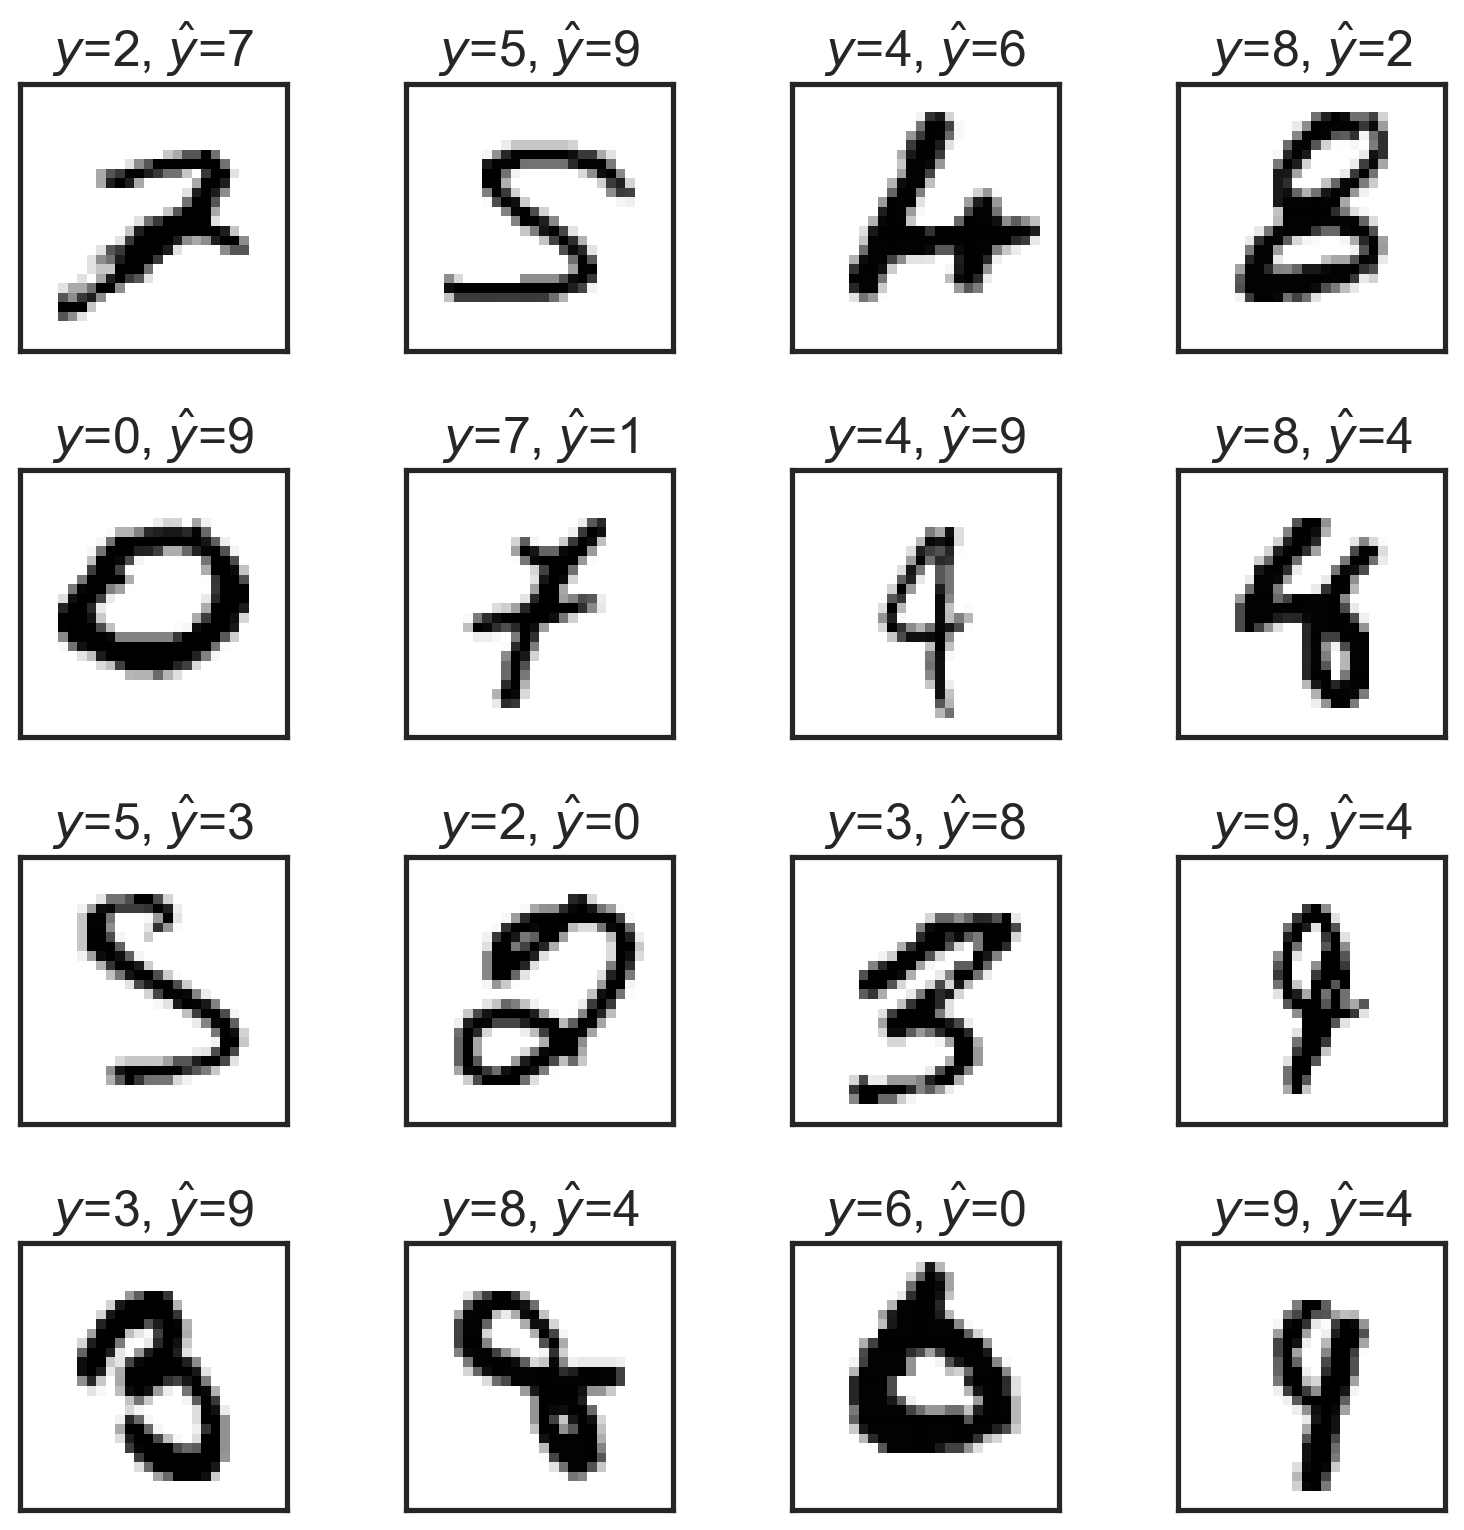

In [68]:
num_cols = 4

idx = y_pred != y_true
choices = jax.random.choice(jax.random.PRNGKey(1), np.arange(idx.size), shape=(num_cols*num_cols,), replace=False, p=idx/idx.sum())

fig, axes = plt.subplots(num_cols, num_cols, figsize=(2*num_cols, 2*num_cols))
for i in range(num_cols):
    for j in range(num_cols):
        choice = choices[i*num_cols+j]
        display_image(X_test[choice], ax=axes[i,j])
        axes[i,j].set_title('{}={}, {}={}'.format('$y$', y_true[choice], r'$\hat{y}$', y_pred[choice]))
fig.tight_layout()

# Problems

One major problem is that FFN learns the relationship $W_{k,j}$ between pixel (feature) $x_j$ and digit (category) $k$, but if we move the pixels around without changing the category, the relationship is lost.
The model sees the features as a sequence of length 728, and it doesn't "know" that it's actually a 2D matrix of 28x28.

Because of that, it can't tell that a shifted 5 is still a 5.

5


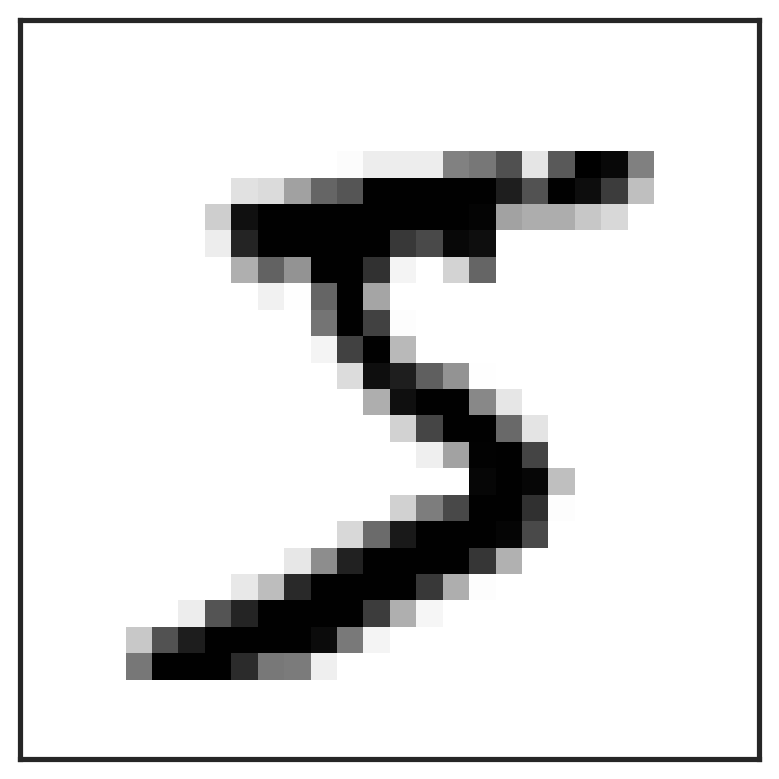

In [69]:
im = X_train[0]
print(predict(Ws, im).argmax())
display_image(im)

`scipy.ndimage` has a bunch of useful image analysis functions, but also see *scikit-image*.

2


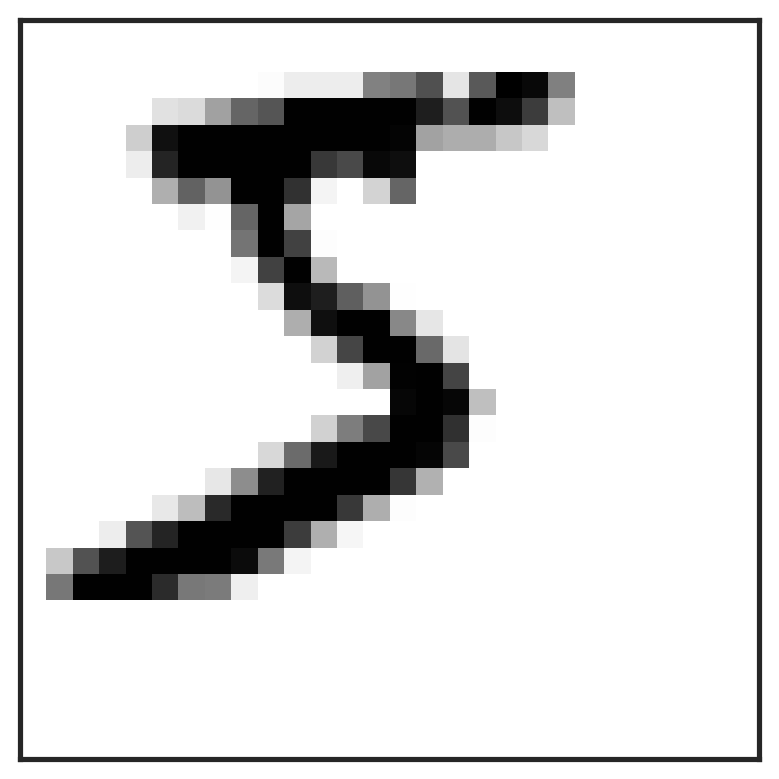

In [72]:
shifted = scipy.ndimage.shift(im.reshape((28, 28)), -3)
print(predict(Ws, shifted.ravel()).argmax())
display_image(shifted)

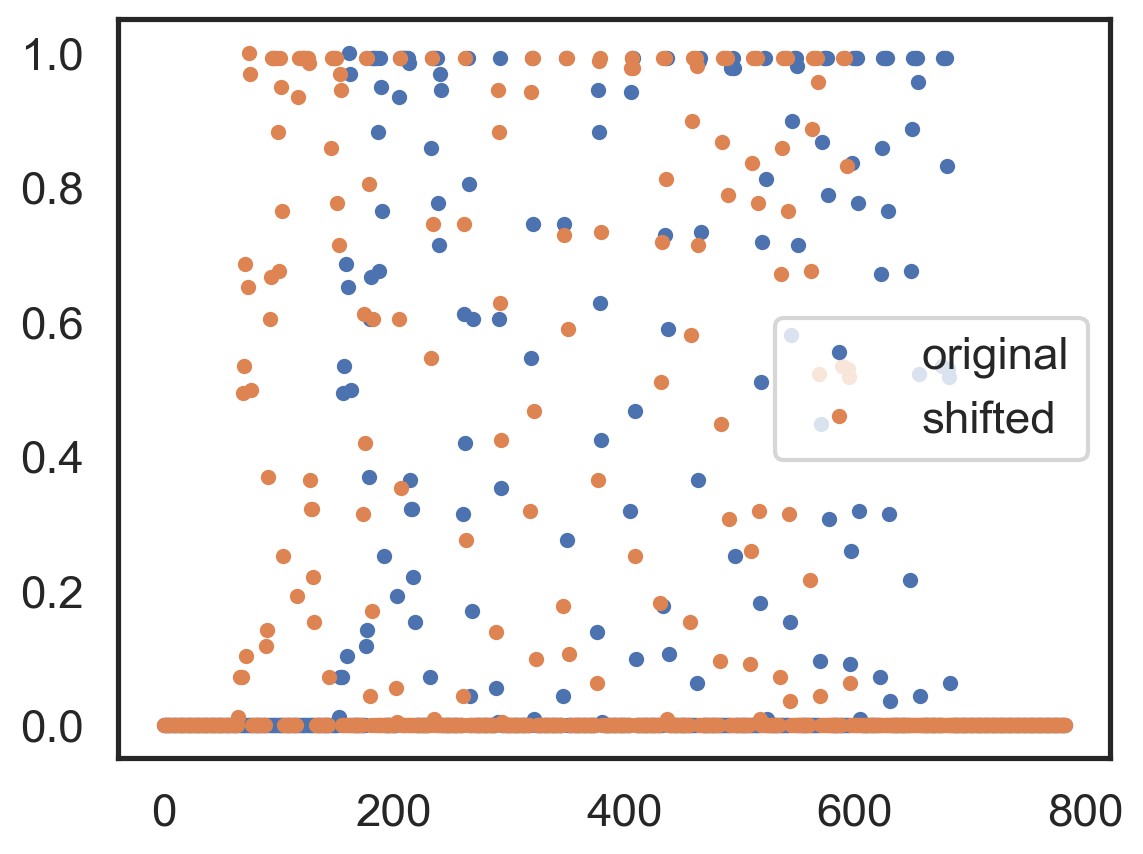

In [73]:
plt.plot(im.ravel(), '.', label='original')
plt.plot(shifted.ravel(), '.', label='shifted')
plt.legend();

A solution to this, which also offers other benefics such as faster training and more efficient memory use, is the use of *convolutional neural networks*, which use convolutions instead of fully connected (matrix multiplcation) layers.
We will deal with such networks later.

# References

- ProbML - [Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html) by Kevin P. Murphy. Online version. June 26, 2024
- [Deep Learning by Ian Goodfellow and Yoshua Bengio and Aaron Courville](http://www.deeplearningbook.org), ch. 6, 7.12, and 8 - offers a comprehensive introduction to the subject.
- [Deep Learning: Technical introduction by Thomas Epelbaum](https://github.com/tomepel/Technical_Book_DL), ch. 4 - offers a very technical perspective with full derivation of all the formulas.

These books are available online for free.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)